In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import math
from tqdm import tqdm

In [2]:
class Scene():
    def __init__(self, H, W, r=0.1, light=np.array([0,0,1]), view=np.array([0,0,1])):
        self.H = H
        self.W = W
        self.r = r
        
        self.image = np.ones((H, W, 3), dtype=np.uint8) * 10
        self.z_buffer = np.full((H,W), np.inf)
        self.models = {}
        self.light = light
        self.t = np.array([W//2, H//2])
        self.view = view


    '''
    ЗАГРУЗКА МОДЕЛИ
    '''
    def load_model(self, name_model, obj_file_path, texture_file_path=None):
        
        def read_obj_file(file_path):
            points = []
            polygons = [[],[]]
            res_cords = []
            with open(file_path, 'r') as file:
                for line in file:
                    parts = line.strip().split()
                    if parts:
                        if parts[0] == 'vt': #координата текстуры
                            point = tuple(map(float, parts[1:3]))
                            res_cords.append(point)
                        elif parts[0] == 'v':  # Вершины
                            point = tuple(map(float, parts[1:4]))
                            points.append(point)
                        elif parts[0] == 'f':  # полигоны
                            
                            face = [int(p.split('/')[0]) - 1 for p in parts[1:]]
                            res_pol = [int(p.split('/')[1]) - 1 for p in parts[1:]]

                            for i in range(1, len(face)-1):
                                polygons[0].append([face[0], face[i], face[i+1]])
                                polygons[1].append([res_pol[0], res_pol[i], res_pol[i+1]])
            return points, polygons, res_cords
        
        point_list, face_list, res_coords = read_obj_file(obj_file_path)
        if texture_file_path is not None:
            texture = np.array(Image.open(texture_file_path))
        else:
            texture = None
        
        self.models[name_model] = {'point_list': point_list,
                                     'face_list': face_list,
                                     'res_coords':res_coords,
                                     'texture': texture}
        return self.models[name_model]


    '''
    ПОВОРОТ И СДВИГ МОДЕЛИ (ЭЙЛЕР)
    '''
    def rotate_model_euler(self, name_model, alpha, beta, gamma, shift=np.array([0,0,0]), scale=1):

        alpha = alpha * np.pi/180
        beta = beta * np.pi/180
        gamma = gamma * np.pi/180
        
        Rx = np.array([[1,                           0,            0],
                       [0,               np.cos(alpha), np.sin(alpha)],
                       [0,              -np.sin(alpha), np.cos(alpha)]])
        
        Ry = np.array([[ np.cos(beta),                0, np.sin(beta)],
                       [            0,                1,            0],
                       [-np.sin(beta),                0, np.cos(beta)]])
        
        Rz = np.array([[ np.cos(gamma),  np.sin(gamma),             0],
                       [-np.sin(gamma),  np.cos(gamma),             0],
                       [             0,              0,             1]])
        
        R = Rz @ Ry @ Rx
        
        def rotate(cords, R, shift):
            return scale * (R @ cords) + shift
        
        def cos_angle_of_light(norm, light):
            length_norm = np.linalg.norm(norm)
            return np.dot(norm, light)/length_norm

        rotated_list = []
        
        # ПОВОРОТ
        for x,y,z in self.models[name_model]['point_list']:
            rotated_list.append(rotate(np.array((x,y,z)), R, shift))

    
        self.models[name_model]['point_list'] = rotated_list

    '''
    ПОВОРОТ И СДВИГ МОДЕЛИ (КВАТЕРНИОНЫ)
    '''
    def rotate_model_quat(self, name_model, roll, pitch, yaw, shift=np.array([0,0,0]), scale=1):
        """
        Поворот модели с использованием кватернионов
        :param name_model: имя модели
        :param roll: угол крена (в градусах)
        :param pitch: угол тангажа (в градусах)
        :param yaw: угол рысканья (в градусах)
        :param shift: вектор сдвига
        """
        roll = np.radians(roll)
        pitch = np.radians(pitch)
        yaw = np.radians(yaw)
        
        # Вычисляем компоненты кватерниона
        cr, sr =  math.cos(roll * 0.5), math.sin(roll * 0.5)
        cp, sp = math.cos(pitch * 0.5), math.sin(pitch * 0.5)
        cy, sy = math.cos(yaw * 0.5), math.sin(yaw * 0.5)
        
        
        # Создаем кватернион поворота
        qw = cr * cp * cy + sr * sp * sy
        qx = sr * cp * cy - cr * sp * sy
        qy = cr * sp * cy + sr * cp * sy
        qz = cr * cp * sy - sr * sp * cy
        
        R = np.array([
            [1 - 2*qy*qy - 2*qz*qz, 2*qx*qy - 2*qz*qw,     2*qx*qz + 2*qy*qw],
            [2*qx*qy + 2*qz*qw,     1 - 2*qx*qx - 2*qz*qz, 2*qy*qz - 2*qx*qw],
            [2*qx*qz - 2*qy*qw,     2*qy*qz + 2*qx*qw,     1 - 2*qx*qx - 2*qy*qy]
        ])
        
        # Применяем поворот и сдвиг ко всем вершинам модели
        rotated_list = []
        for x, y, z in self.models[name_model]['point_list']:
            rotated_point = scale * (R @ np.array([x, y, z])) + shift
            rotated_list.append(tuple(rotated_point))
        
        self.models[name_model]['point_list'] = rotated_list

        
    '''
    ОТРИСОВКА МОДЕЛИ НА СЦЕНЕ
    '''
    def render_scene(self, name_model, S, color=None):
        old_image = self.image.copy()
        
        def norm(x0, y0, z0, x1, y1, z1, x2, y2, z2):
            return np.cross(np.array((x1-x2, y1-y2, z1-z2)), np.array((x1-x0, y1-y0, z1-z0)))

        def caol(norm, light=self.light):
                length_norm = np.linalg.norm(norm)
                return np.dot(norm, light)/length_norm
            
        def shading_Guro(n0, n1, n2, light=[0,0,1]):
            return np.array((n0 @ light, n1 @ light, n2 @ light))

        def bar_coords(x, y, x0, y0, x1, y1, x2, y2):
             lambda0 = ((x - x2) * (y1 - y2) - (x1 - x2) * (y - y2)) / ((x0 - x2) * (y1 - y2) - (x1 - x2) * (y0 - y2))
             lambda1 = ((x0 - x2) * (y - y2) - (x - x2) * (y0 - y2)) / ((x0 - x2) * (y1 - y2) - (x1 - x2) * (y0 - y2))
             lambda2 = 1.0 - lambda0 - lambda1
             return lambda0, lambda1, lambda2

        '''ОТРИСОВКА ТРЕУГОЛЬНИКА'''
        def draw_triangle_v5(points_dict, z_buff, image, x0, y0, z0, x1, y1, z1, x2, y2, z2, color, S, t, texture, uv):

            norm_p = norm(x0, y0, z0, x1, y1, z1, x2, y2, z2)
            
            cos_of_light = caol(
                norm_p,
                self.view
            )
            
            if cos_of_light >= 0:
                return image
            
            px0,py0 = self.r * S * np.array((x0,y0)) / (z0+self.r) + self.t
            px1,py1 = self.r * S * np.array((x1,y1)) / (z1+self.r) + self.t
            px2,py2 = self.r * S * np.array((x2,y2)) / (z2+self.r) + self.t
        
            x_min = max(min((px0, px1, px2)), 0)
            x_max = min(max((px0, px1, px2)), self.W)
        
            y_min = max(min((py0, py1, py2)), 0)
            y_max = min(max((py0, py1, py2)), self.H)
        
            for x in range(math.floor(x_min), math.ceil(x_max)):
                for y in range(math.floor(y_min), math.ceil(y_max)):
                    bar_c = np.array(bar_coords(x, y, px0, py0, px1, py1, px2, py2))
        
                    if self.z_buffer[y,x] < np.dot(np.array((z0, z1, z2)), bar_c):
                        continue
                        
                    if np.all(bar_c >= 0):
                        self.z_buffer[y][x] = np.dot(np.array((z0, z1, z2)), bar_c)
        
                        i = shading_Guro(
                            points_dict[(x0,y0,z0)]/np.linalg.norm(points_dict[(x0,y0,z0)]),
                            points_dict[(x1,y1,z1)]/np.linalg.norm(points_dict[(x1,y1,z1)]),
                            points_dict[(x2,y2,z2)]/np.linalg.norm(points_dict[(x2,y2,z2)])
                        )
                        I = max(-bar_c @ i, 0)
                        #print(I)
                        if color is None:
                            y_texture = -int(texture.shape[0]*(bar_c @ np.array((uv[0][1], uv[1][1], uv[2][1]))))
                            x_texture = int(texture.shape[1]*(bar_c @ np.array((uv[0][0], uv[1][0], uv[2][0]))))
                            image[y][x] = texture[y_texture][x_texture] * I
                        else:
                            image[y][x] = color*I
            return image

        
        # Затенение Гуро (считаем нормали для точек)
        points_dict = dict()
        for d in self.models[name_model]['face_list'][0]:
            (x0,y0,z0), (x1,y1,z1), (x2,y2,z2) = (self.models[name_model]['point_list'][i] for i in d)
            norm_p = norm(x0, y0, z0, x1, y1, z1, x2, y2, z2)
            
            for x,y,z in ((x0, y0, z0), (x1, y1, z1), (x2, y2, z2)):
                if (x, y, z) not in points_dict:
                    points_dict[(x,y,z)] = norm_p
                else:
                    points_dict[(x,y,z)] += norm_p
                
        
        
        for d,textur in tqdm(list(zip(self.models[name_model]['face_list'][0], self.models[name_model]['face_list'][1]))):
    
            (x0,y0,z0), (x1,y1,z1), (x2,y2,z2) = (np.array(self.models[name_model]['point_list'][i]) for i in d)
            
            if color is None:
                (u0,v0), (u1,v1), (u2,v2) = (np.array(self.models[name_model]['res_coords'][i]) for i in textur)
                uv = np.array([(u0,v0), (u1,v1), (u2,v2)])
            else:
                uv = None
            draw_triangle_v5(points_dict, self.z_buffer, self.image,
                             x0, y0, z0,
                             x1, y1, z1,
                             x2, y2, z2,
                             color, S, self.t, self.models[name_model]['texture'], uv)
        return self.image, old_image
    '''
    СОХРАНЕНИЕ МОДЕЛИ
    '''
    def save_image(self, file_path):
        img = Image.fromarray(scene.image, mode='RGB').convert('P')
        img.save(file_path)

    '''
    ВЫВОД ИЗОБРАЖЕНИЯ КАК ФАЙЛА
    '''
    def get_image(self):
        return Image.fromarray(self.image).transpose(Image.FLIP_TOP_BOTTOM).convert('P')

In [9]:
scene = Scene(500, 1000, light=np.array([1,0,0]))

In [10]:
scene.load_model('bunny', "model_1.obj", "bunny.jpg")
scene.rotate_model_quat("bunny", 0, -90, 0, [0.08, -0.05, 0.05], scale=1)
a,b = scene.render_scene("bunny", 5000);

100%|██████████████████████████████████████████████████████████████████████████| 30338/30338 [00:07<00:00, 3955.74it/s]


In [11]:
scene.load_model('bunny1', "model_1.obj", "bunny.jpg")
scene.rotate_model_quat("bunny1", 0, -180, 0, [0, -0.05, 0.05], scale=1)
a,b = scene.render_scene("bunny1", 5000);

100%|██████████████████████████████████████████████████████████████████████████| 30338/30338 [00:06<00:00, 4495.68it/s]


In [12]:
scene.load_model('frog', "frog.obj", "frog.jpg")
scene.rotate_model_quat("frog", 90, 70, 180, [-0.1, -0.05, 0.05], scale=0.02) # жаба оказалась сильно больше чем заяц
a,b = scene.render_scene("frog", 5000);

100%|██████████████████████████████████████████████████████████████████████████| 58016/58016 [00:10<00:00, 5790.94it/s]


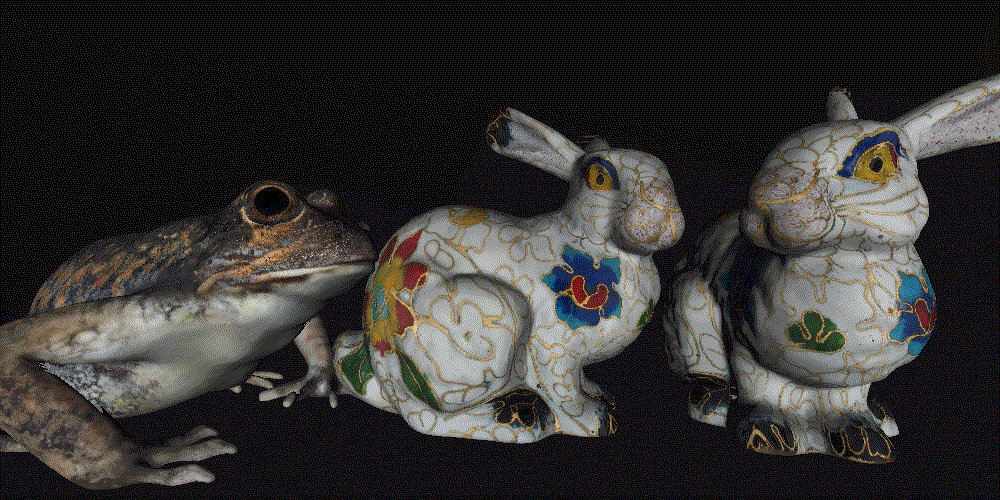

In [13]:
scene.get_image()

In [8]:
scene.save_image('final.png')